In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def plot_two_columns(df, colname):
    col1 = colname + '_beam'
    col2 = colname + '_asim'
    df_plot = df[[col1, col2]]
    ax = df_plot.plot.hist(bins=50, alpha=0.5)

In [3]:
def add_simulation_vars(households, accessibilities, land_use):
    """
    Generate dataframe with the variables that are needed for simulation according to the model specification. 
    Input: 
    - Households: DataFrame with household table (Simulation resuls)
    - accessibilities: DataFrame. Accessibilities table (Simulation Result)
    - land_use: DataFrame. Land use table (Simulation result)
    
    Output: 
    - Dataframe with needed variables to simulate the car ownership model. 
    """
    #Merge accesibilities and land use variables 
    hh_merge = households.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['util_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['util_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['util_drivers_4_up'] = hh_merge.num_drivers > 3
    hh_merge['util_persons_16_17'] = hh_merge.num_children_16_to_17
    hh_merge['util_persons_18_24'] = hh_merge.num_college_age #College
    hh_merge['util_persons_25_34'] = hh_merge.num_young_adults #Young adults
    hh_merge['util_presence_children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['util_presence_children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['util_num_workers_clip_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['util_hh_income_0_30k'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['util_hh_income_30_75k'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['util_hh_income_75k_up'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['util_density_0_10_no_workers'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['util_density_10_up_no_workers'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['util_density_0_10_workers'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['util_density_10_up_workers'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    
    #ASC
    hh_merge['util_asc'] = 1
    hh_merge['util_asc_san_francisco'] = 0   
    hh_merge['util_asc_solano'] = 0 
    hh_merge['util_asc_napa'] = 0 
    hh_merge['util_asc_sonoma'] = 0 
    hh_merge['util_asc_marin'] = 0 
    
    #Accessibility_based variables
    hh_merge['util_retail_auto_no_workers'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['util_retail_auto_workers'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['util_retail_transit_no_workers'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['util_retail_transit_workers'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['util_retail_non_motor_no_workers'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['util_retail_non_motor_workers'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['util_auto_time_saving_per_worker'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

## Loading resutls 

In [53]:
#ActivitySim data 
hh = pd.read_csv('../01_aa/data/households.csv')

In [216]:
pp1 = hdf1['/persons/trip_mode_choice']
pp4 = hdf4['/persons/trip_mode_choice']

In [222]:
pp1[['home_taz','workplace_taz','distance_to_work', 'workplace_in_cbd', 
     'roundtrip_auto_time_to_work','work_auto_savings', 
     'work_auto_savings_ratio']][~pp1.distance_to_work.isnull()]

,home_taz,workplace_taz,distance_to_work,workplace_in_cbd,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio
person_id,,,,,,,
72384,59,16,6.250000,True,31.139999,46.110901,0.384257
73370,131,12,5.210000,True,23.040001,40.181396,0.334845
73513,134,1008,15.700000,True,62.620003,69.551598,0.579597
74405,170,132,1.120000,False,5.920000,35.763199,0.298027
75327,208,100,6.610000,True,25.869999,233.130005,1.000000
...,...,...,...,...,...,...,...
7519946,940,1021,4.730000,False,22.920000,48.314400,0.402620
7520094,996,10,10.120000,True,42.119999,64.375000,0.536458
7521516,1008,1008,0.220000,True,1.440000,7.360000,0.061333


In [221]:
pp1.columns

Index(['household_id', 'age', 'PNUM', 'sex', 'pemploy', 'pstudent', 'ptype',
       'age_16_to_19', 'age_16_p', 'adult', 'male', 'female', 'has_non_worker',
       'has_retiree', 'has_preschool_kid', 'has_driving_kid', 'has_school_kid',
       'has_full_time', 'has_part_time', 'has_university',
       'student_is_employed', 'nonstudent_to_school', 'is_student',
       'is_gradeschool', 'is_highschool', 'is_university', 'school_segment',
       'is_worker', 'home_taz', 'value_of_time', 'school_taz',
       'school_taz_logsum', 'distance_to_school',
       'roundtrip_auto_time_to_school', 'workplace_taz',
       'workplace_location_logsum', 'distance_to_work', 'workplace_in_cbd',
       'work_taz_area_type', 'roundtrip_auto_time_to_work',
       'work_auto_savings', 'work_auto_savings_ratio', 'free_parking_at_work',
       'cdap_activity', 'travel_active', 'under16_not_at_school',
       'has_preschool_kid_at_home', 'has_school_kid_at_home',
       'mandatory_tour_frequency', 'work_and_s

In [224]:
pp4[['home_taz','workplace_taz','distance_to_work', 'workplace_in_cbd', 
     'roundtrip_auto_time_to_work','work_auto_savings', 
     'work_auto_savings_ratio']][~pp4.distance_to_work.isnull()]

,home_taz,workplace_taz,distance_to_work,workplace_in_cbd,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio
person_id,,,,,,,
8639,482,425,7.097802,False,18.520000,-17.468334,-0.145569
9399,512,535,16.967302,False,37.038334,690.686768,1.000000
9400,512,773,35.626865,False,67.213333,1417.351318,1.000000
9651,511,583,13.523703,False,26.799999,545.046814,1.000000
9652,511,625,15.393524,False,28.700001,626.773987,1.000000
...,...,...,...,...,...,...,...
6739684,336,322,5.257388,False,18.209999,-17.406832,-0.145057
6740088,336,338,1.845803,True,5.520000,-5.028000,-0.041900
6740090,336,140,27.926611,False,50.243332,-47.780666,-0.398172


In [71]:
## 01_aa 
hdf1 = pd.HDFStore('../01_aa/output/pipeline.h5')
hh1 = hdf1['/households/trip_mode_choice']
acc1 = hdf1['/accessibility/trip_mode_choice']
lu1 = hdf1['/land_use/trip_mode_choice']

## 02_ua 
hdf2 = pd.HDFStore('../02_au/output/pipeline.h5')
hh2 = hdf2['/households/trip_mode_choice']
acc2 = hdf2['/accessibility/trip_mode_choice']
lu2 = hdf2['/land_use/trip_mode_choice']

## 03_ua 
hdf3 = pd.HDFStore('../03_ua/output/pipeline.h5')
hh3 = hdf3['/households/trip_mode_choice']
acc3 = hdf3['/accessibility/trip_mode_choice']
lu3 = hdf3['/land_use/trip_mode_choice']


## 04_uu 
hdf4 = pd.HDFStore('output/pipeline.h5')
hh4 = hdf4['/households/trip_mode_choice']
acc4 = hdf4['/accessibility/trip_mode_choice']
lu4 = hdf4['/land_use/trip_mode_choice']

In [45]:
hh1['VEHICL'] = hh1['auto_ownership']

In [46]:
# MTC variable 
mtc_df = add_simulation_vars(hh1, acc1, lu1)

# UrbanSim + Beam variables 
usim_df = add_simulation_vars(hh2, acc2, lu2)

#Auto ownership variables:
variables = ['util_drivers_2', 'util_drivers_3', 'util_drivers_4_up',
       'util_persons_16_17', 'util_persons_18_24', 'util_persons_25_34',
       'util_presence_children_0_4', 'util_presence_children_5_17',
       'util_num_workers_clip_3', 'util_hh_income_0_30k',
       'util_hh_income_30_75k', 'util_hh_income_75k_up',
       'util_density_0_10_no_workers', 'util_density_10_up_no_workers',
       'util_density_0_10_workers', 'util_density_10_up_workers','util_retail_auto_no_workers',
       'util_retail_auto_workers', 'util_retail_transit_no_workers',
       'util_retail_transit_workers', 'util_retail_non_motor_no_workers',
       'util_retail_non_motor_workers', 'util_auto_time_saving_per_worker']

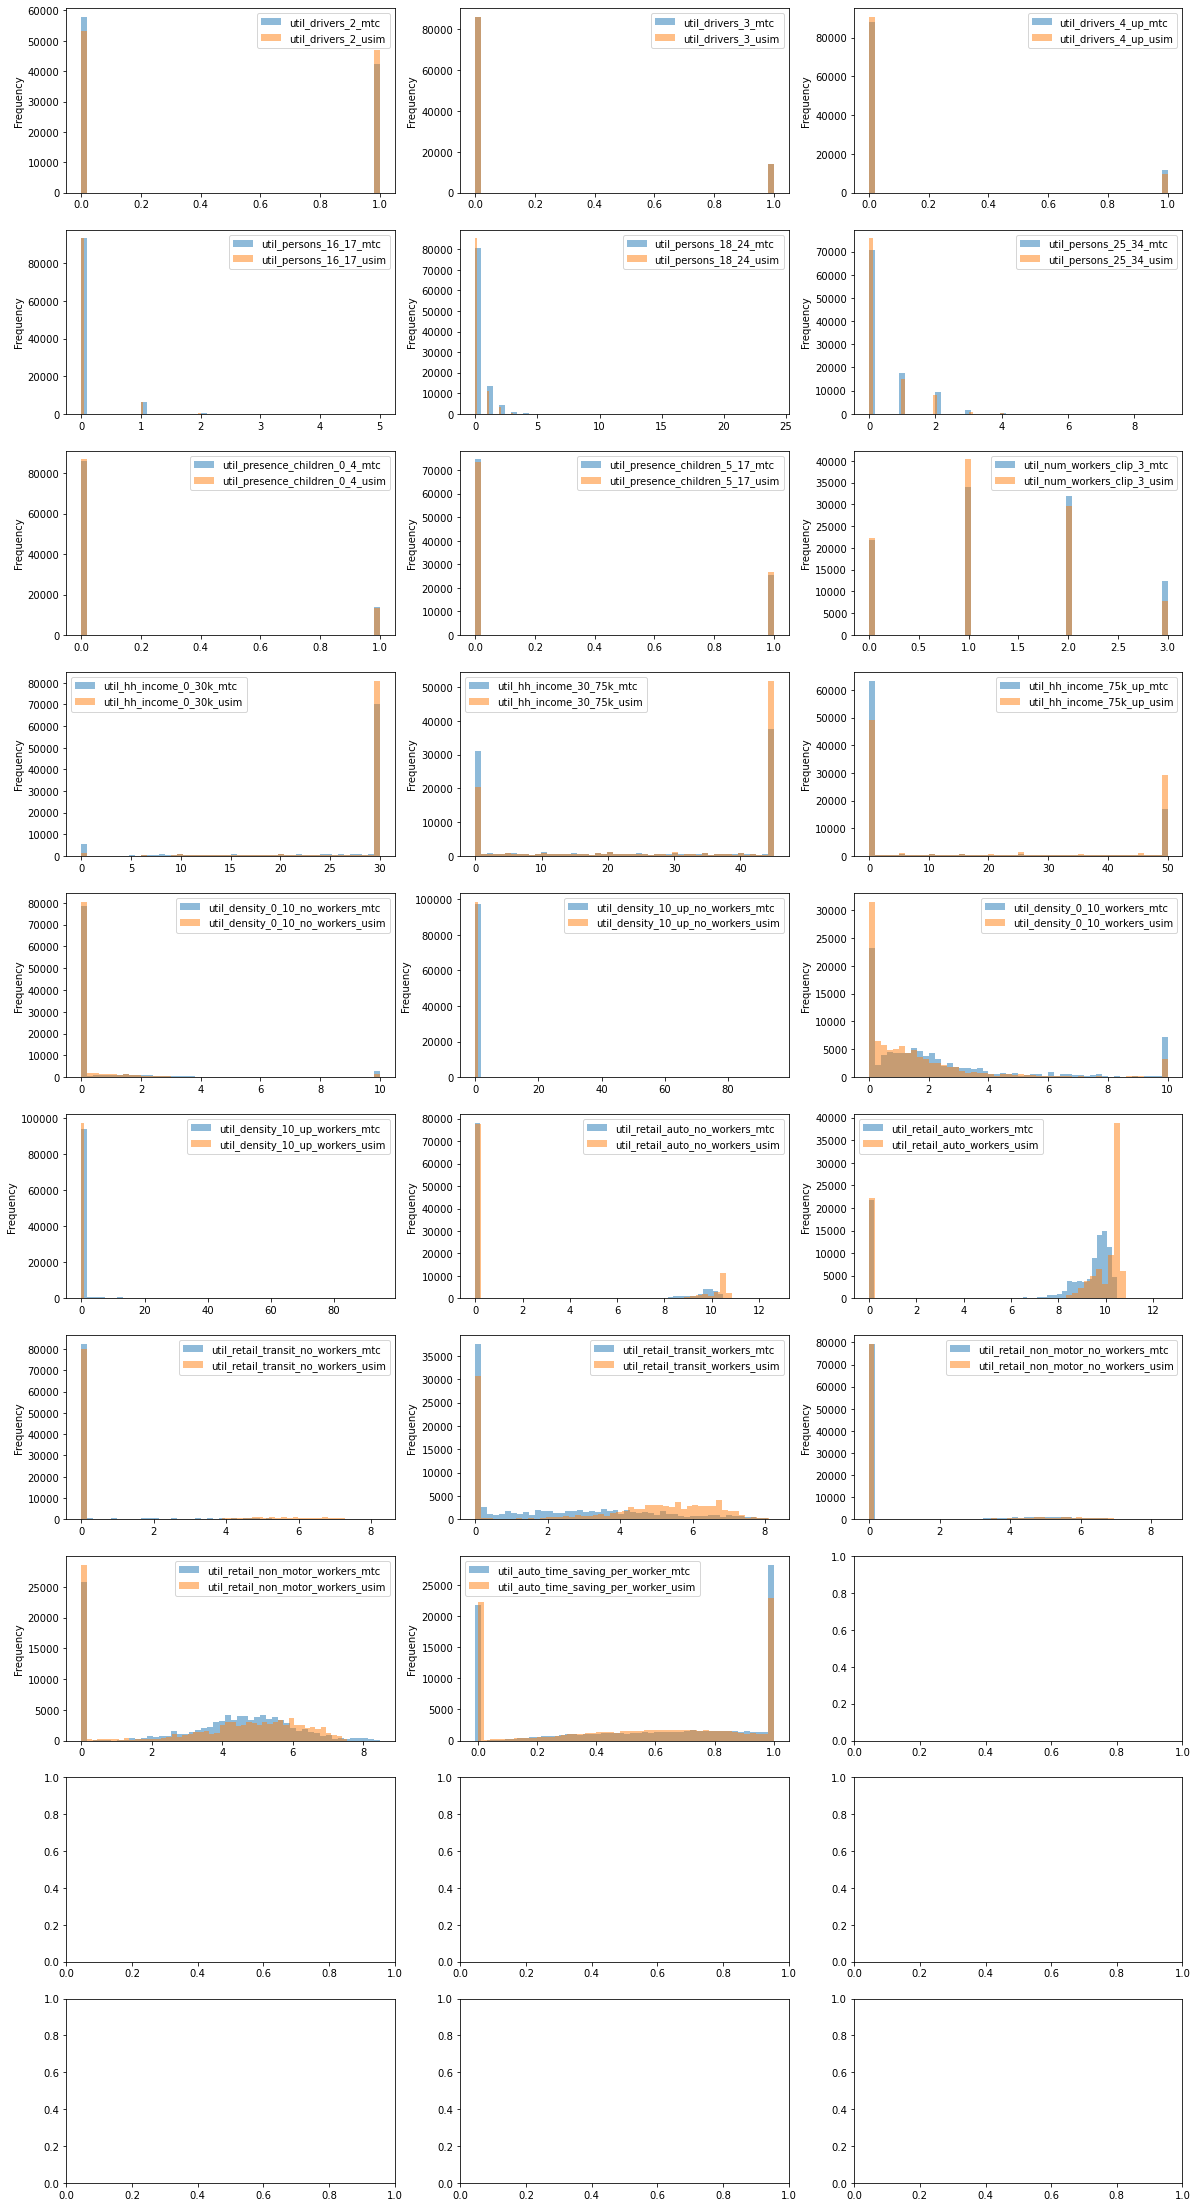

In [47]:
nrows, ncols = 10, 3
fig, axs = plt.subplots(nrows, ncols, figsize = (20,40) )

counter = 0
for i in range(nrows):
    for j in range(ncols):
        try: 
            col1, col2 = mtc_df[variables[counter]] * 1, usim_df[variables[counter]] * 1
            name1, name2 = col1.name + '_mtc', col2.name + '_usim'
            col1.plot.hist(legend = True, bins=50, alpha=0.5, ax = axs[i,j], label = name1)
            col2.plot.hist(legend = True, bins=50, alpha=0.5, ax = axs[i,j], label = name2);
            counter += 1
        except IndexError:
            col1, col2 = 0, 0 

## Accessibility variables 

### Comparing accessibility distributions 

In [48]:
accs = acc2.merge(acc3, right_index = True, left_index = True, suffixes=('_beam', '_asim'))

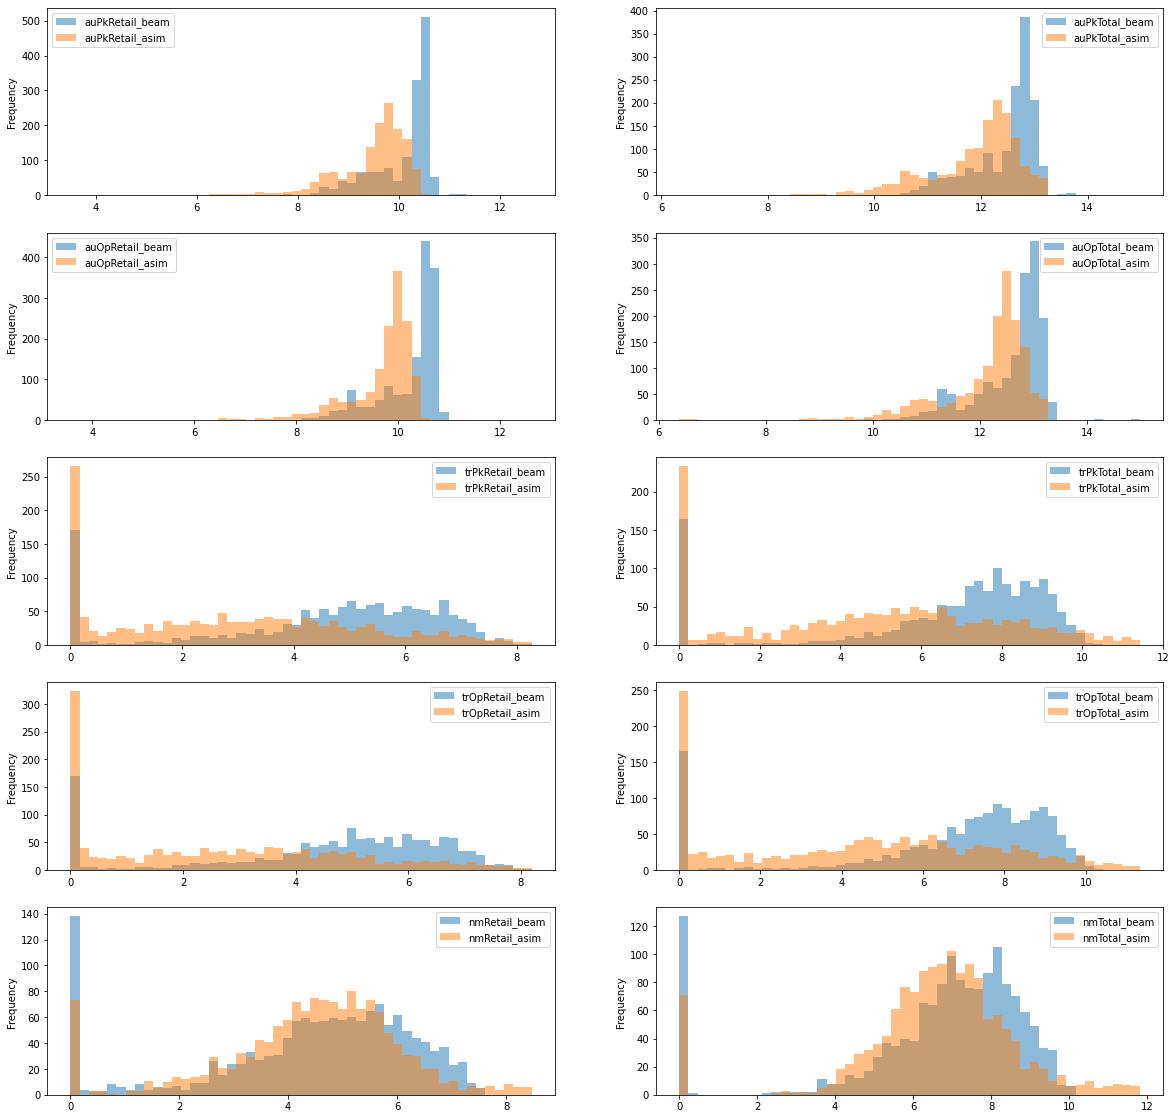

In [49]:
nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize = (20,20) )

counter = 0
for i in range(nrows):
    for j in range(ncols):

        col1 = acc4.columns[counter] + '_beam'
        col2 = acc4.columns[counter] + '_asim'
        df_plot = accs[[col1, col2]]
        df_plot.plot.hist(bins=50, alpha=0.5, ax = axs[i,j])
        counter += 1

### Comparing accessibilities differences 

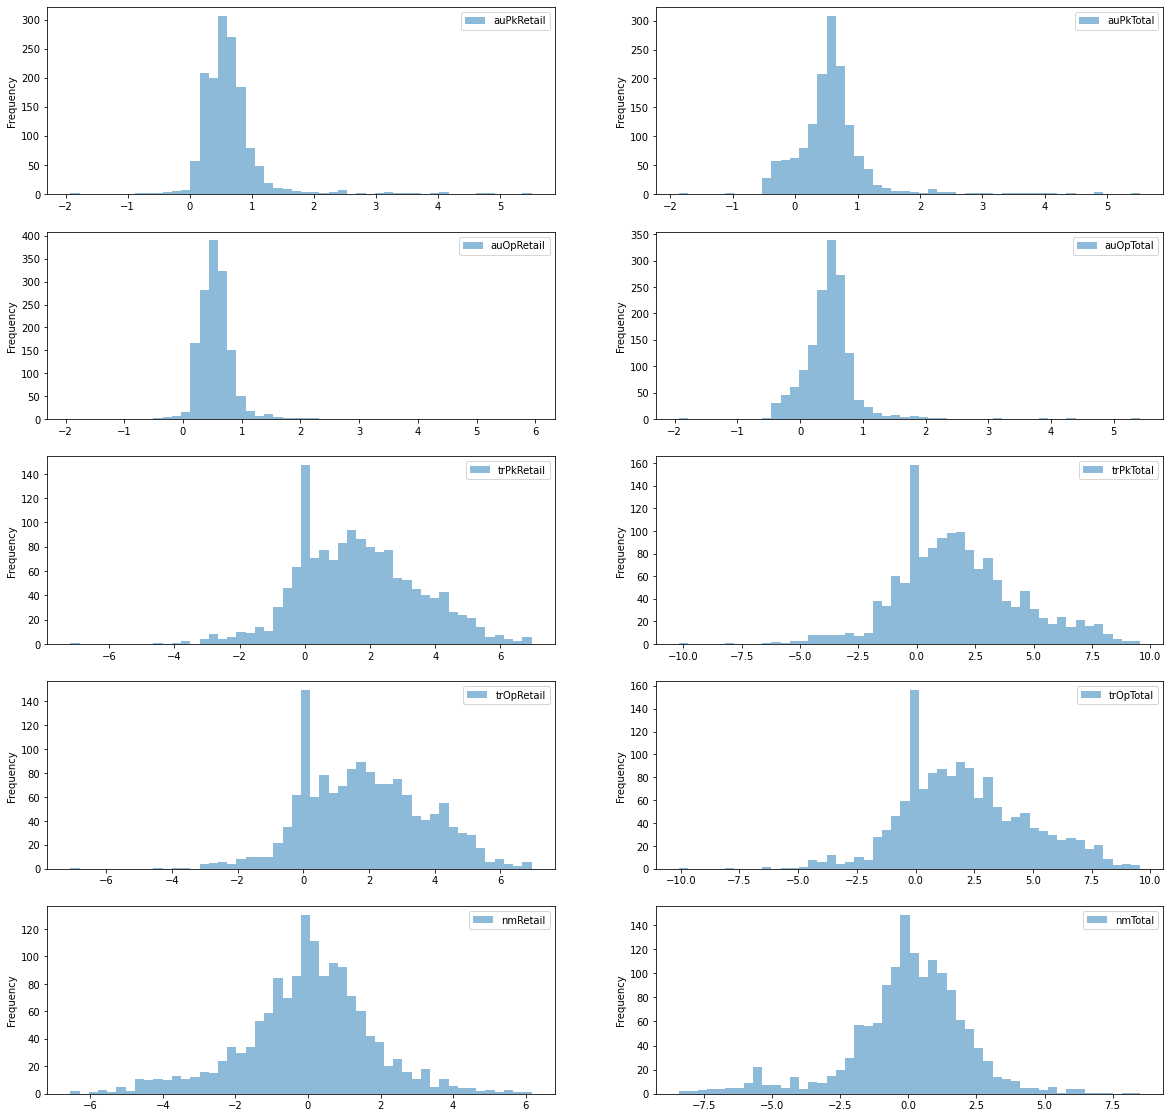

In [50]:
nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize = (20,20) )

counter = 0
for i in range(nrows):
    for j in range(ncols):

        col1 = acc4.columns[counter] + '_beam'
        col2 = acc4.columns[counter] + '_asim'
        col = accs[col1] - accs[col2]
        col.plot.hist(bins=50, alpha=0.5, ax = axs[i,j], label = acc4.columns[counter], legend = True)
        counter += 1

### Mapping accessibilities 

In [51]:
# Import TAZ zoning 
# Merge TAZ zoning with the corresponding accesbilities. Get comparing plots of both of them (And the differences)
geo_ba = gpd.read_file('Transportation_Analysis_Zones.shp')

In [56]:
#MTC Accessibilities 
#Beam accessibilities 
mtc_geo = geo_ba.merge(acc1, right_index =True, left_on = 'taz1454')
beam_geo = geo_ba.merge(acc2, right_index =True, left_on = 'taz1454')

In [57]:
def plot_acc(mtc_geo, beam_geo, var_name):
    nrows, ncols = 1 , 2
    min_value = min(mtc_geo[var_name].min(), beam_geo[var_name].min())
    max_value = max(mtc_geo[var_name].max(), beam_geo[var_name].max())

    fig, axs = plt.subplots(nrows, ncols, figsize = (20,8), sharex=True, sharey=True,)
    # divider = make_axes_locatable(axs[0])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    mtc_geo.plot(column = var_name, legend = True, ax = axs[0],  vmin=min_value, vmax = max_value)
    axs[0].set_title('MTC-based accessibilites\n' + var_name, fontsize=14, fontweight='bold')

    # divider = make_axes_locatable(axs[1])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    beam_geo.plot(column = var_name, legend = True, ax = axs[1],  vmin=min_value, vmax = max_value)
    axs[1].set_title('BEAM-based accessibilites\n' + var_name, fontsize=14, fontweight='bold');

In [58]:
accs_names = [ 'auPkRetail', 'auPkTotal', 'auOpRetail','auOpTotal',
               'trPkRetail', 'trPkTotal', 'trOpRetail', 'trOpTotal',
               'nmRetail', 'nmTotal']

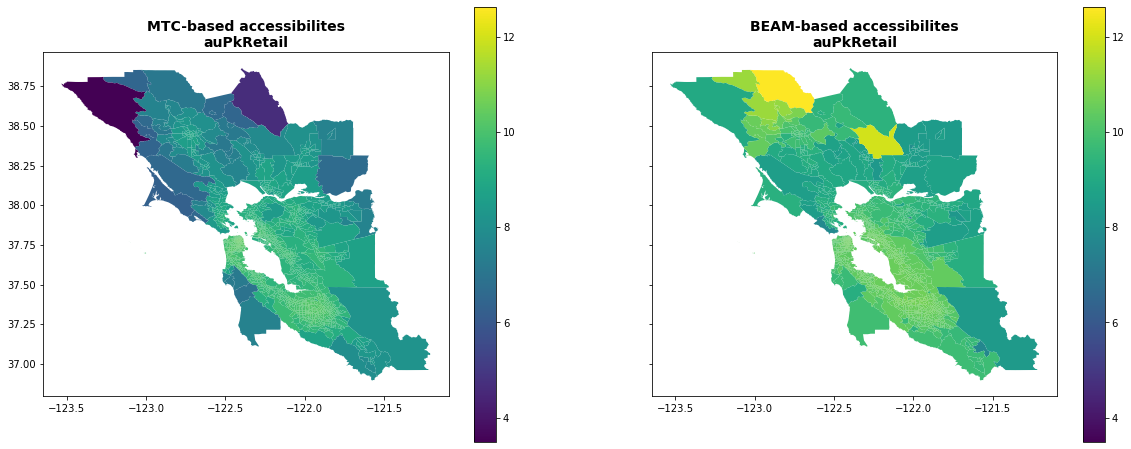

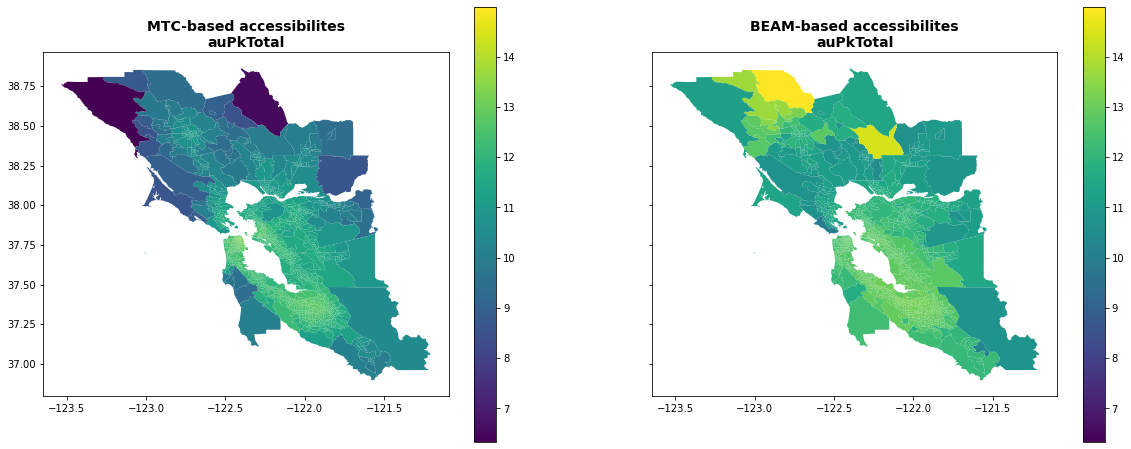

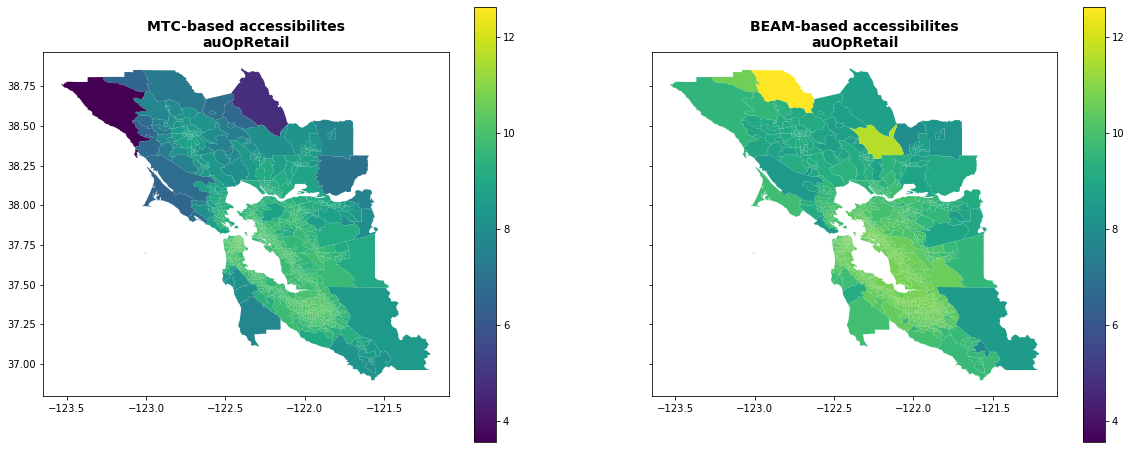

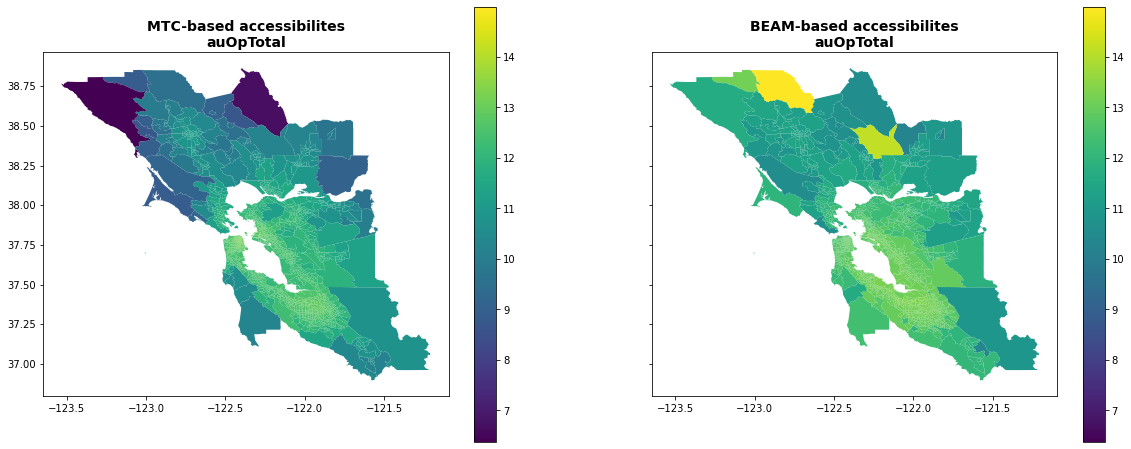

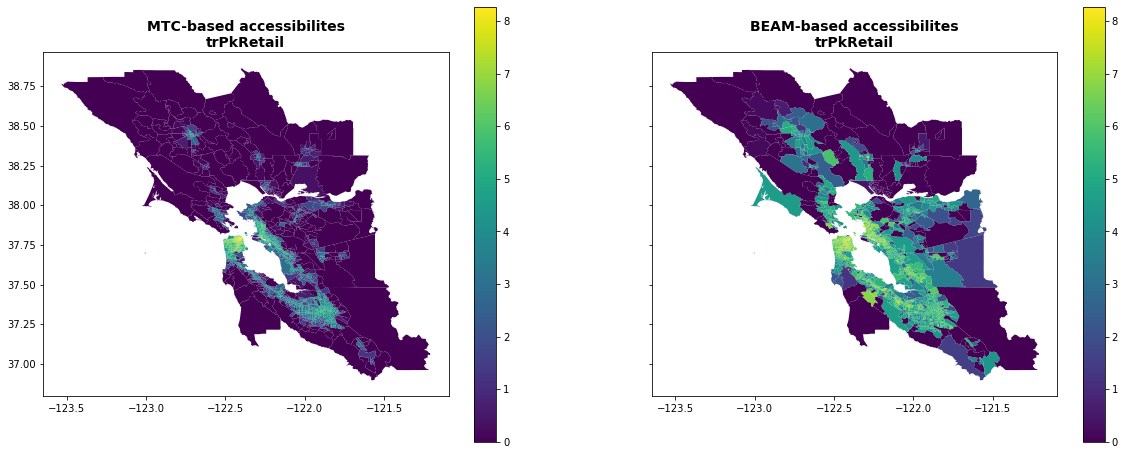

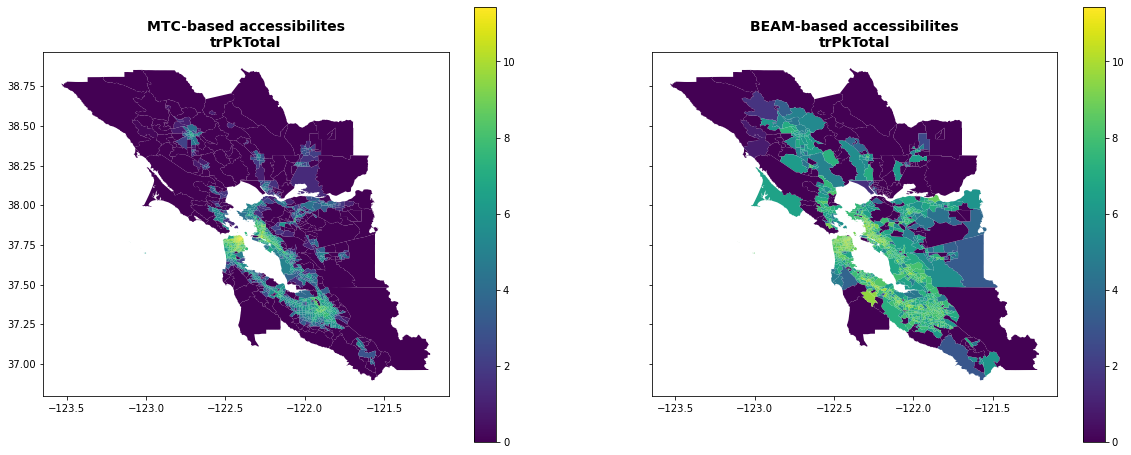

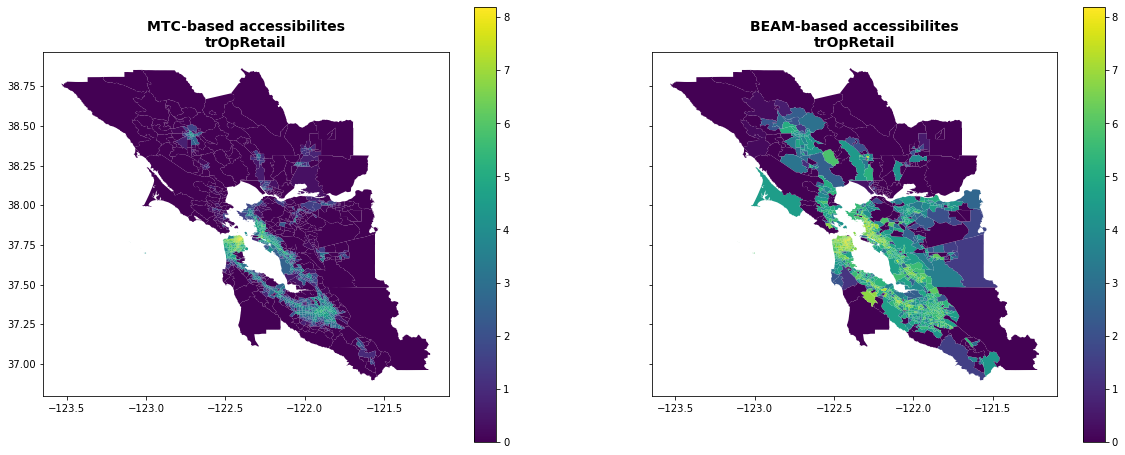

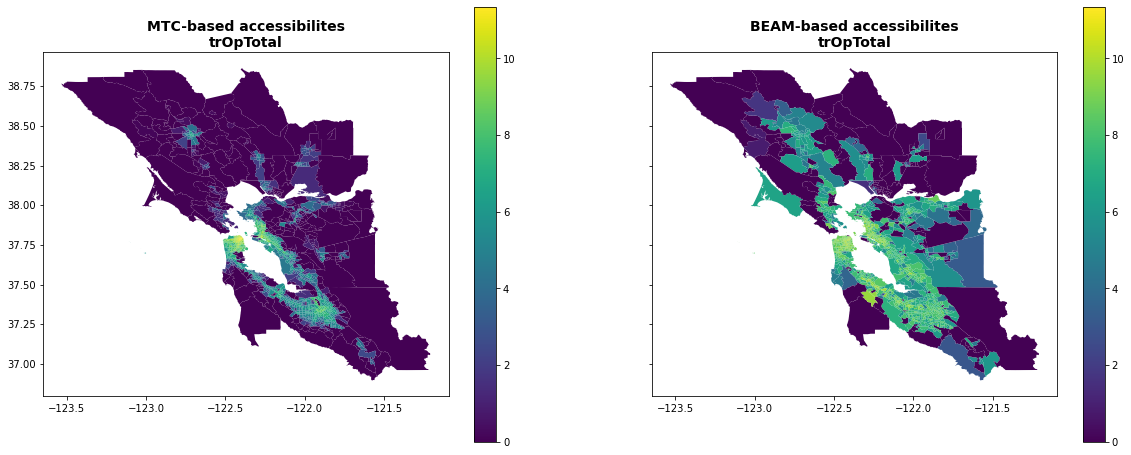

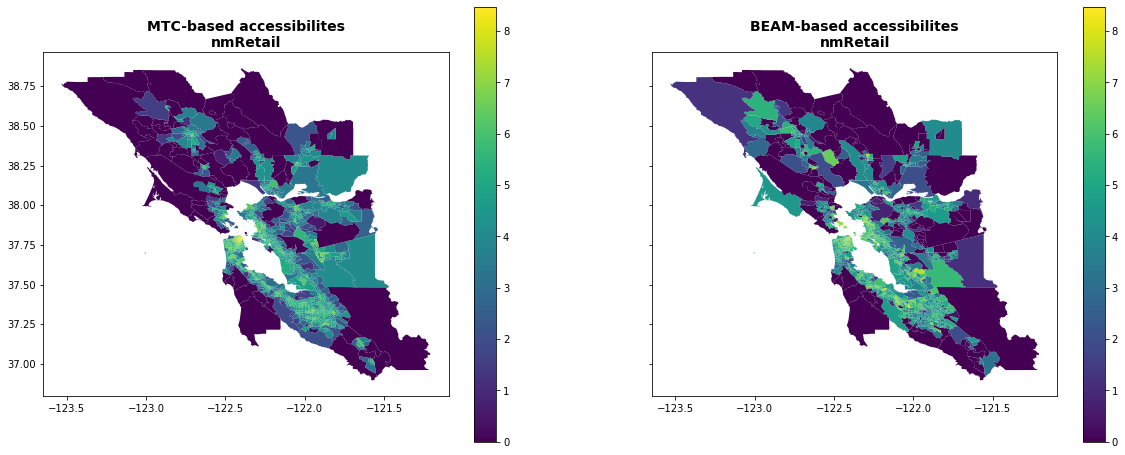

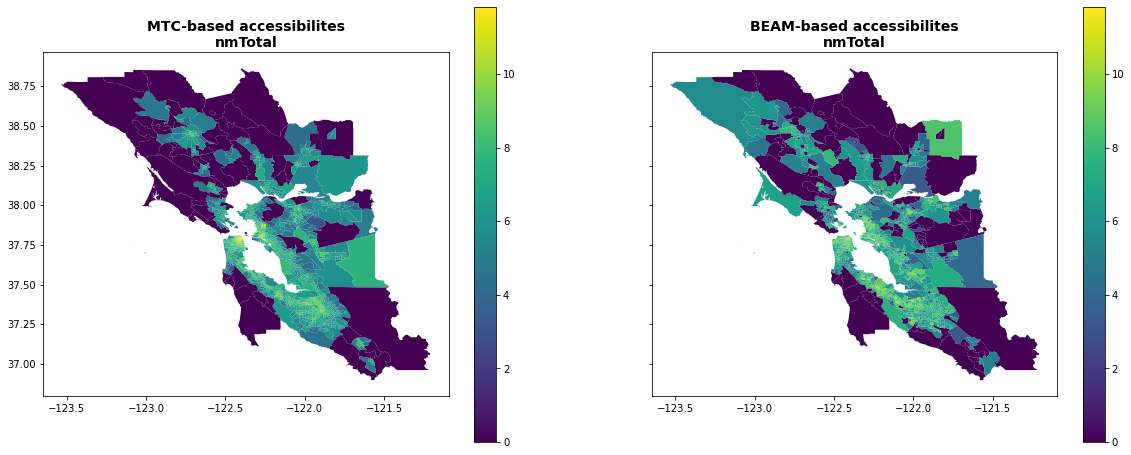

In [59]:
for var_name in accs_names:
    plot_acc(mtc_geo, beam_geo, var_name)

In [207]:
hh4['hh_work_auto_savings_ratio']

household_id
1181326   -0.421756
2071946   -0.082722
2372135   -0.190886
1047791   -0.700924
1467118    0.000000
             ...   
586789     1.000000
1256059    1.839494
172685    -1.012860
1057314    0.000000
2557205    0.000000
Name: hh_work_auto_savings_ratio, Length: 100000, dtype: float32

In [206]:
hh1['hh_work_auto_savings_ratio']

household_id
1244122    1.022962
2396364    2.000000
2111986    1.446887
753467     1.551083
1904639    1.472174
             ...   
1780641    1.044285
1818946    3.000000
617822     0.000000
2859488    0.000000
2658794    2.846492
Name: hh_work_auto_savings_ratio, Length: 100000, dtype: float32

In [23]:
hdf4 = pd.HDFStore('../02_au/output/pipeline.h5')

In [24]:
hdf4.keys()

['/checkpoints',
 '/workplace_modeled_size/trip_mode_choice',
 '/workplace_destination_size/trip_mode_choice',
 '/trips/trip_mode_choice',
 '/tours/trip_mode_choice',
 '/school_modeled_size/trip_mode_choice',
 '/school_destination_size/trip_mode_choice',
 '/persons/trip_mode_choice',
 '/person_windows/trip_mode_choice',
 '/land_use/init',
 '/land_use/trip_mode_choice',
 '/joint_tour_participants/trip_mode_choice',
 '/households/trip_mode_choice',
 '/accessibility/trip_mode_choice']

In [25]:
trips = hdf4['/trips/trip_mode_choice']
tours = hdf4['/tours/trip_mode_choice']

In [73]:
trips = hdf1['/trips/trip_mode_choice']
tours = hdf1['/tours/trip_mode_choice']

trips['number_of_participants'] = trips['tour_id'].map(
        tours['number_of_participants'])
trips['mode_type'] = 'drive'
transit_modes = ['COM', 'EXP', 'HVY', 'LOC', 'LRF', 'TRN']
active_modes = ['WALK', 'BIKE']
trips.loc[
        trips['trip_mode'].str.contains('|'.join(transit_modes)),
        'mode_type'] = 'transit'
trips.loc[trips['trip_mode'].isin(active_modes), 'mode_type'] = 'active'
expanded_trips = trips.loc[
        trips.index.repeat(trips['number_of_participants'])]
mode_shares = expanded_trips[
        'mode_type'].value_counts() / len(expanded_trips)
mode_shares = np.round(mode_shares * 100, 1)
    ##
mode_shares
    ##
#     logger.warning(
#         "MODE SHARES -- drive: {0}% // transit: {1}% // active: {2}%".format(
#             mode_shares['drive'], mode_shares['transit'],
#             mode_shares['active']))


drive      81.8
active     10.6
transit     7.6
Name: mode_type, dtype: float64

In [74]:
trips = hdf2['/trips/trip_mode_choice']
tours = hdf2['/tours/trip_mode_choice']

trips['number_of_participants'] = trips['tour_id'].map(
        tours['number_of_participants'])
trips['mode_type'] = 'drive'
transit_modes = ['COM', 'EXP', 'HVY', 'LOC', 'LRF', 'TRN']
active_modes = ['WALK', 'BIKE']
trips.loc[
        trips['trip_mode'].str.contains('|'.join(transit_modes)),
        'mode_type'] = 'transit'
trips.loc[trips['trip_mode'].isin(active_modes), 'mode_type'] = 'active'
expanded_trips = trips.loc[
        trips.index.repeat(trips['number_of_participants'])]
mode_shares = expanded_trips[
        'mode_type'].value_counts() / len(expanded_trips)
mode_shares = np.round(mode_shares * 100, 1)
    ##
mode_shares
    ##
#     logger.warning(
#         "MODE SHARES -- drive: {0}% // transit: {1}% // active: {2}%".format(
#             mode_shares['drive'], mode_shares['transit'],
#             mode_shares['active']))


drive      79.3
active     10.6
transit    10.0
Name: mode_type, dtype: float64

In [27]:
mode_shares['drive']

88.2

In [30]:
mode_shares.keys()

Index(['drive', 'active'], dtype='object')

In [28]:
mode_shares['transit']

KeyError: 'transit'

In [20]:
mode_shares['active']

9.7

In [187]:
tours[tours.household_id == 866761]

,person_id,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination,origin,...,end,duration,composition,destination_logsum,tour_mode,mode_choice_logsum,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose
tour_id,,,,,,,,,,,,,,,,,,,,,
93102716,2270797,work,1,1,1,1,mandatory,1,913.0,974.0,...,19.0,13.0,,NaN,TNC_SINGLE,4.169387,no_subtours,NaN,0out_1in,work
93102790,2270799,school,1,1,1,1,mandatory,1,977.0,974.0,...,14.0,7.0,,NaN,WALK,15.996454,,NaN,0out_0in,school
93102839,2270800,work,1,1,1,1,mandatory,1,923.0,974.0,...,17.0,9.0,,NaN,TNC_SINGLE,4.160999,no_subtours,NaN,1out_2in,work
93102746,2270798,othmaint,1,1,1,1,non_mandatory,1,1000.0,974.0,...,15.0,3.0,,14.211148,SHARED2FREE,0.919918,,NaN,0out_0in,othmaint
93102765,2270799,eatout,1,1,1,1,non_mandatory,1,1003.0,974.0,...,21.0,7.0,,14.058238,SHARED3PAY,0.876360,,NaN,1out_0in,eatout


In [62]:
hdf2['/tours/trip_mode_choice'].tour_mode.unique()

array(['DRIVEALONEFREE', 'DRIVEALONEPAY', 'SHARED2PAY', 'SHARED2FREE',
       'WALK', 'SHARED3PAY', 'SHARED3FREE', 'TNC_SHARED', 'TNC_SINGLE',
       'BIKE', 'TAXI'], dtype=object)

In [184]:
mask_1 = hh2.num_workers > 1
mask_2 = hh2.income < 20000
mask_3 = hh2.auto_ownership == 0
hh2[(mask_1) & (mask_2) & (mask_3)]

,serialno,hhsize,VEHICL,income,race_of_head,age_of_head,num_workers,children,tenure,recent_mover,...,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours
household_id,,,,,,,,,,,,,,,,,,,,,
185260,2.013001e+12,2,0,2700,6,20,2,0,2,1,...,1.000681,0,2,2,0,0,2,True,1_Shop,1
1034341,2.011000e+12,2,2,12090,1,32,2,0,2,0,...,0.488174,0,2,2,0,0,2,True,0_tours,0
518395,2.010001e+12,2,2,13300,2,48,2,0,2,0,...,0.419506,0,2,2,0,0,2,True,0_tours,0
1940377,2.009001e+12,3,0,13360,6,18,3,0,2,1,...,0.752300,0,3,3,0,0,3,True,0_tours,0
2088544,2.013001e+12,3,1,13660,2,50,2,0,2,0,...,1.172181,0,3,3,0,0,3,True,0_tours,0
2101545,2.011000e+12,3,2,13000,6,53,2,0,2,0,...,0.383778,0,3,3,0,0,3,True,0_tours,0
2085993,2.011000e+12,3,2,13000,6,53,2,0,2,0,...,0.929458,0,3,3,0,0,3,True,0_tours,0
1073209,2.013001e+12,2,0,15150,1,61,2,0,2,0,...,0.367639,0,2,2,0,0,2,True,0_tours,0
1233150,2.010001e+12,2,2,13200,1,51,2,0,2,0,...,1.828977,0,2,2,0,0,2,True,0_tours,0


In [67]:
hh2[hh2.income < 20000].sort_values('income').tail(50)

,serialno,hhsize,VEHICL,income,race_of_head,age_of_head,num_workers,children,tenure,recent_mover,...,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours
household_id,,,,,,,,,,,,,,,,,,,,,
775044,2.013000e+12,3,2,19800,1,27,2,1,2,1,...,1.987333,1,3,2,1,1,2,True,0_tours,0
2157916,2.009001e+12,1,1,19820,1,73,0,0,1,1,...,0.000000,0,1,1,0,0,1,False,0_tours,0
394470,2.012000e+12,6,2,19900,2,36,0,4,2,0,...,0.000000,1,4,1,0,3,4,True,0_tours,0
1564225,2.010000e+12,2,1,19900,6,54,1,0,2,1,...,0.487623,0,1,1,0,0,1,False,0_tours,0
2299825,2.013000e+12,3,0,19900,2,25,0,2,2,0,...,0.000000,2,3,1,2,2,1,True,0_tours,0
1968759,2.009001e+12,3,1,19900,6,54,2,1,2,0,...,0.618038,0,3,2,0,1,3,True,0_tours,0
1981410,2.009001e+12,3,1,19900,6,54,2,1,2,0,...,1.104958,0,3,2,0,1,3,True,0_tours,0
388402,2.012000e+12,6,2,19900,2,36,0,4,2,0,...,0.000000,0,5,1,1,4,4,True,0_tours,0
2299507,2.013000e+12,3,0,19900,2,25,0,2,2,0,...,0.000000,1,3,1,2,2,1,True,1_Disc,1


In [98]:
# tours_1 = hdf1['/tours/trip_mode_choice']
# tours_1.tour_mode.unique()

trips = hdf1['/trips/trip_mode_choice']
tours = hdf1['/tours/trip_mode_choice']

trips['number_of_participants'] = trips['tour_id'].map(
        tours['number_of_participants'])
trips['mode_type'] = 'drive'
transit_modes = ['COM', 'EXP', 'HVY', 'LOC', 'LRF', 'TRN']
active_modes = ['WALK', 'BIKE']
trips.loc[
        trips['trip_mode'].str.contains('|'.join(transit_modes)),
        'mode_type'] = 'transit'
trips.loc[trips['trip_mode'].isin(active_modes), 'mode_type'] = 'active'
expanded_trips = trips.loc[
        trips.index.repeat(trips['number_of_participants'])]
mode_shares = expanded_trips[
        'mode_type'].value_counts() / len(expanded_trips)
mode_shares = np.round(mode_shares * 100, 1)
    ##
mode_shares#.keys()
    ##
#     logger.warning(
#         "MODE SHARES -- drive: {0}% // transit: {1}% // active: {2}%".format(
#             mode_shares['drive'], mode_shares['transit'],
#             mode_shares['active']))


drive      81.8
active     10.6
transit     7.6
Name: mode_type, dtype: float64

In [57]:
import openmatrix as omx

In [44]:
beam_skims.close()
mtc_skims.close()

In [58]:
skims_path = '../02_au/data/skims.omx'
beam_skims = omx.open_file(skims_path, 'a')

skims_path_mtc = '../01_aa/data/skims.omx'
mtc_skims = omx.open_file(skims_path_mtc, 'a')

In [64]:
beam = beam_skims['WLK_LOC_WLK_BOARDS__EA']
mtc = mtc_skims['WLK_LOC_WLK_BOARDS__EA']

# taz_equivs = np.arange(1,1476)
# mtc_skims.create_mapping('taz', taz_equivs)

In [65]:
map_beam = beam_skims.mapping('taz') 
map_mtc = mtc_skims.mapping('taz')
# skims.list_mappings()

In [66]:
beam[map_beam[974]][map_beam[923]]

100.0

In [67]:
mtc[map_mtc[974]][map_mtc[923]]

1.0

In [42]:
np.array(mtc).max()

544.0

In [41]:
np.array(beam)

array([[1792.46323529,    0.        , 1726.42973856, ..., 4339.65482026,
           0.        , 6857.32230392],
       [   0.        , 1815.03267974, 1726.42973856, ..., 4339.65482026,
           0.        , 6857.32230392],
       [1673.3251634 , 1673.3251634 ,    0.        , ..., 4344.30147059,
           0.        , 5831.07638889],
       ...,
       [6789.60375817, 6789.60375817, 7475.66380719, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 2453.6254085 ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [70]:
3 == 4 or 4==3

False